### Introduction

In the production of electrical drives, a high product quality is needed. As the industry of electric drive production is confronted by trends such as electric mobility and continuing industrial automation, efficient and flexible processes are needed more than ever. With current quality monitoring technology, accurate quality checking is not feasible. 

Electrical motors mainly consist of the rotor, the stator and the surrounding housing. The production process can be separated into multiple sub-processes, which can be seen below. The exact sequence of these steps however depends on the motor type. First, the individual components are manufactured and assembled into subassemblies such as the rotor and the stator. Finally, all components (the housing, the stator, the rotor as well as bearings and end shields) are assembled and the motor is checked in an end-of-line (EOL) test.

This final assembly is of great importance, as all parts need to be assembled in the correct way, to ensure smooth operation. Therefore, a quality monitoring system is needed, raising alarm if assembly errors are detected. However, especially in lot-size one production, traditional computer vision systems might reach their limits and cannot be used anymore. 

Thus, in this lab we will build a smart quality monitoring system for the electric drives production. An already existing visual sensor captures images of the electric motor after assembly. These images show the part from the top, as well from the side perspective. It is now the target to decide whether the motor is fully assembled, or whether one of multiple defects is present. There is data from three different defects available: *missing cover*, *missing screw* and *not screwed*. Examples of these defects can be seen below. To achieve this, we will investigate two different machine learning models: *Support Vector Machines* (SVM) and *Convolutional Neural Networks* (CNN).

Further background information can be found in this paper: [Mayr et al., Machine Learning in Electric Motor Production - Potentials, Challenges and Exemplary Applications](https://ieeexplore.ieee.org/document/9011861)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import glob
import random
import tensorflow as tf

In [2]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import sys, os
drive.mount('/content/gdrive')

# Depending on your directory, you may want to adjust this
dir_path = '/content/gdrive/MyDrive/Quality monitoring for EV motors/Image_Classification'
sys.path.append(dir_path)
os.chdir(dir_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data preprocessing
Located in the folder called *data*. Within this folder, two subfolders can be found:
- The folder **top** contains the top view of each motor
- The folder **side** contains the side view of each motor

Each motor is uniquely identified by its filename.

In [3]:
# Loading one array of an example image
path = "./data/top/L1_C_3.JPG"
img = cv2.imread(path)
img.shape

(1024, 1024, 3)

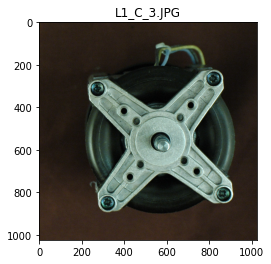

In [4]:
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

By default, open cv assumes the images are encoded in blue, green and red. However, the actual order of the color channels is blue, red and green. Thus, the channels need to be converted using `cv2.COLOR_BGR2RGB`.

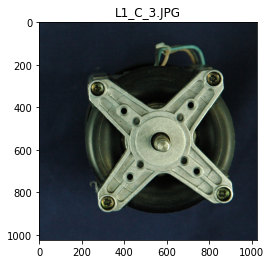

In [5]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert image from bgr to rgb
plt.title(path.split('/')[-1]) # Set the filename as image title
plt.imshow(img) # Display the image
plt.show()

- *features* containing all the images as numpy arrays
- *labels* containing the classes of all images

In [6]:
def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # TODO: Raise error

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            features.append( cv2.imread(file))
            labels.append(get_label_from_name(file))
    
    return features, labels # Return results

In [7]:
features, labels = load_features_labels("./data/top")
print("Number of features:", len(features))
print("Number of labels:", len(labels))

Number of features: 117
Number of labels: 117


In [8]:
def image_preprocessing(img, size = (64,32), flatten = True, color = False):
    img = cv2.resize(img, size)
    if not color:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if flatten:
        img = img.reshape(-1)
    return img

In [9]:
def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] # Empty lists for storing the features and labels
    # Iterate over all imagefiles in the given folder
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            img=cv2.imread(file)
            img=image_preprocessing(img,size,flatten,color)
            features.append(img)
            labels.append(get_label_from_name(file))

    return features, labels # Return results

## First data analysis

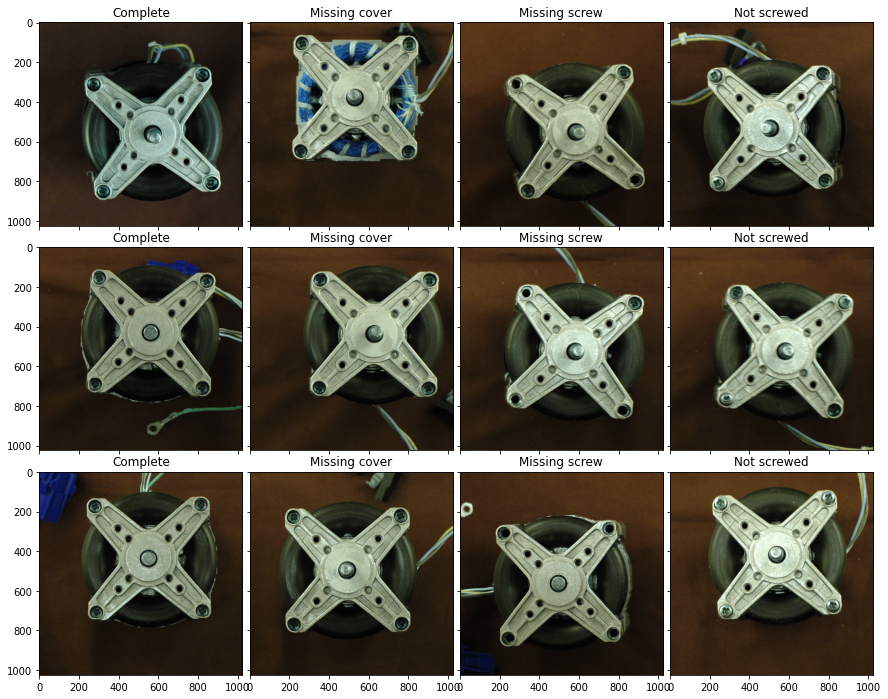

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

features, labels = load_features_labels("./data/top", size=(1024, 1024), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']
for i, ax in enumerate(grid):
    #print(i, ax,i%4 )
    selectedClass = classes[i%4] # Select class
    images = np.array(features)[np.array(labels)==selectedClass] # Preselect images based on class
    #print(type(images))
    image = images[i//4] # Select image 
    #print(images[0])
    ax.imshow(image) # Plot image
    ax.set_title(selectedClass) # Assign class as image title
plt.show()

In [11]:
from collections import Counter
print(Counter(labels))

Counter({'Not screwed': 47, 'Missing screw': 42, 'Missing cover': 22, 'Complete': 6})


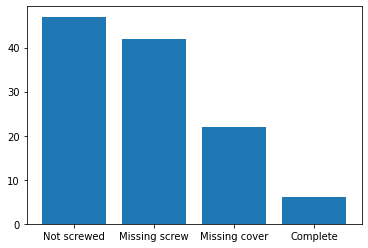

In [12]:
from collections import Counter, OrderedDict
x = Counter(labels)
x2 =OrderedDict(x.most_common())
plt.bar(x2.keys(),x2.values())
plt.show()

## Image classification using Support Vector Machines


In [13]:
features, labels = load_features_labels("./data/top", size=(16,16), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 768)
Shape label vector: (70,)


In [14]:
from sklearn.model_selection import train_test_split

X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [15]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
clf = SVC(kernel="rbf", gamma=0.01, C=0.0003)
clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train))
print("Score:", clf.score(X_test, y_test))

Score: 0.42857142857142855


               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.43      1.00      0.60         9
Missing screw       0.00      0.00      0.00        10

     accuracy                           0.43        21
    macro avg       0.14      0.33      0.20        21
 weighted avg       0.18      0.43      0.26        21



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


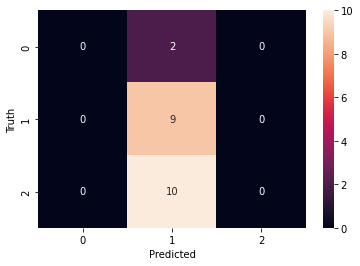

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, clf.predict(X_test))
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, clf.predict(X_test)))

## Image classification with simple ANN

In [17]:
features, labels = load_features_labels("./data/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 49152)
Shape label vector: (70,)


In [18]:
X=features
y=labels
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

The labels need to be *one hot encoded*. In one hot encoding, categorical values are transformed into a binary representation.

In [19]:
from sklearn.preprocessing import OneHotEncoder
# Display the first label before encoding
print("Label of first sample before OneHot encoding:", y_train[0])
# Create the encoder object
enc = OneHotEncoder(sparse=False) # Generate Encoder
# With the fit_transform function, the encoder is fitted to the existing labels and transforms the dataset into its binary representation
y_train = enc.fit_transform(y_train.reshape(-1, 1))
# Display the first label after encoding
print("Label of first sample after OneHot encoding:", y_train[0])
# Data preprocessing should always be fitted on the training dataset, but applied to both, the training and the testing dataset. Thus the fit_transform function is only applied to the training dataset, while the the test dataset is transformed using the transform function and the fitted preprocessing module
y_test = enc.transform(y_test.reshape(-1, 1))

Label of first sample before OneHot encoding: Complete
Label of first sample after OneHot encoding: [1. 0. 0.]


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout

model = Sequential()
model.add(Dense(32, input_shape = X_train[0].shape))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(y_train[0].shape[0]))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1572896   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params: 1,573,475
Trainable params: 1,573,475
Non-

Model needs to be compiled using a `loss` function and an `optimizer`. The loss function defines how the loss is computed during model training, while the optimizer defines how the weights need to be adjusted during backpropagation. 

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [22]:
model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)

Epoch 1/20
5/5 [==============================] - 1s 71ms/step - loss: 365.8752 - accuracy: 0.2821 - val_loss: 165.7780 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 127.7387 - accuracy: 0.6923 - val_loss: 277.6084 - val_accuracy: 0.4000
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 135.5555 - accuracy: 0.7179 - val_loss: 214.0625 - val_accuracy: 0.4000
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 79.3807 - accuracy: 0.6410 - val_loss: 46.9419 - val_accuracy: 0.4000
Epoch 5/20
5/5 [==============================] - 0s 19ms/step - loss: 67.2222 - accuracy: 0.5128 - val_loss: 120.9574 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 55.9558 - accuracy: 0.6154 - val_loss: 98.1971 - val_accuracy: 0.4000
Epoch 7/20
5/5 [==============================] - 0s 19ms/step - loss: 26.4208 - accuracy: 0.6923 - val_loss: 37.6864 - val_accuracy: 0.4000
Epoch 

In [23]:
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report
    
    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         9
Missing screw       0.48      1.00      0.65        10

     accuracy                           0.48        21
    macro avg       0.16      0.33      0.22        21
 weighted avg       0.23      0.48      0.31        21



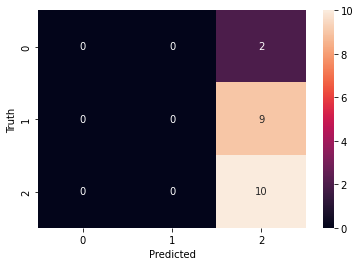

In [24]:
evaluate_model(X_test, y_test, model)

### Image classification using CNNs

In [25]:
features, labels = load_features_labels("./data/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)


In [26]:
def split_data(features, labels):
  return train_test_split(features,labels,test_size=0.3,random_state=42)

def encode_data(y_train, y_test):
    """Your code goes here"""
    enc = OneHotEncoder(sparse=False)
    y_train = enc.fit_transform(y_train.reshape(-1, 1))
    y_test = enc.fit_transform(y_test.reshape(-1, 1))
    return y_train, y_test

X_train, X_test, y_train, y_test = split_data(features, labels)
y_train, y_test = encode_data(y_train, y_test)
print("Label of first sample after OneHot encoding:", y_train[0])

Label of first sample after OneHot encoding: [1. 0. 0.]


In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, GlobalMaxPooling2D

model = Sequential()
model.add(Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(GlobalMaxPooling2D())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train[0].shape[0], activation = 'softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 global_max_pooling2d (Globa  (None, 32)              

In [28]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [29]:
model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 32, validation_split=0.1, 
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

Epoch 1/75
2/2 [==============================] - 11s 3s/step - loss: 17.0557 - accuracy: 0.5682 - val_loss: 13.0764 - val_accuracy: 0.2000
Epoch 2/75
2/2 [==============================] - 9s 3s/step - loss: 10.6118 - accuracy: 0.0682 - val_loss: 5.7594 - val_accuracy: 0.2000
Epoch 3/75
2/2 [==============================] - 9s 3s/step - loss: 4.5040 - accuracy: 0.0682 - val_loss: 4.3825 - val_accuracy: 0.2000
Epoch 4/75
2/2 [==============================] - 10s 3s/step - loss: 1.8295 - accuracy: 0.4545 - val_loss: 6.5670 - val_accuracy: 0.4000
Epoch 5/75
2/2 [==============================] - 10s 3s/step - loss: 1.6798 - accuracy: 0.2727 - val_loss: 4.8058 - val_accuracy: 0.4000
Epoch 6/75
2/2 [==============================] - 9s 3s/step - loss: 1.4702 - accuracy: 0.2273 - val_loss: 2.6009 - val_accuracy: 0.4000
Epoch 7/75
2/2 [==============================] - 10s 3s/step - loss: 1.2289 - accuracy: 0.2500 - val_loss: 2.2596 - val_accuracy: 0.0000e+00
Epoch 8/75
2/2 [==============

               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.56      0.56      0.56         9
Missing screw       0.73      0.80      0.76        10

     accuracy                           0.62        21
    macro avg       0.43      0.45      0.44        21
 weighted avg       0.58      0.62      0.60        21



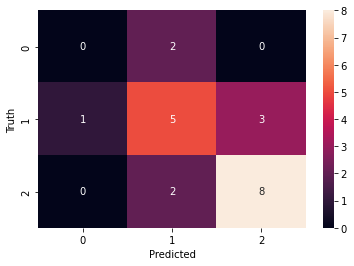

In [30]:
evaluate_model(X_test, y_test, model)

## Data augmentation

Examples of data augmentation:

- Random flipping of the image horizontally or vertically
- Random rotations
- Random shifts
- Blurring the image
- Adding artificially created noise
- Cropping
- Changes in contrast
- Elastic deformations

https://keras.io/api/preprocessing/image/#imagedatagenerator-classData



In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
### Create and show data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [33]:
random_index = random.randint(0, len(features)) # Randomly select one image
datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image

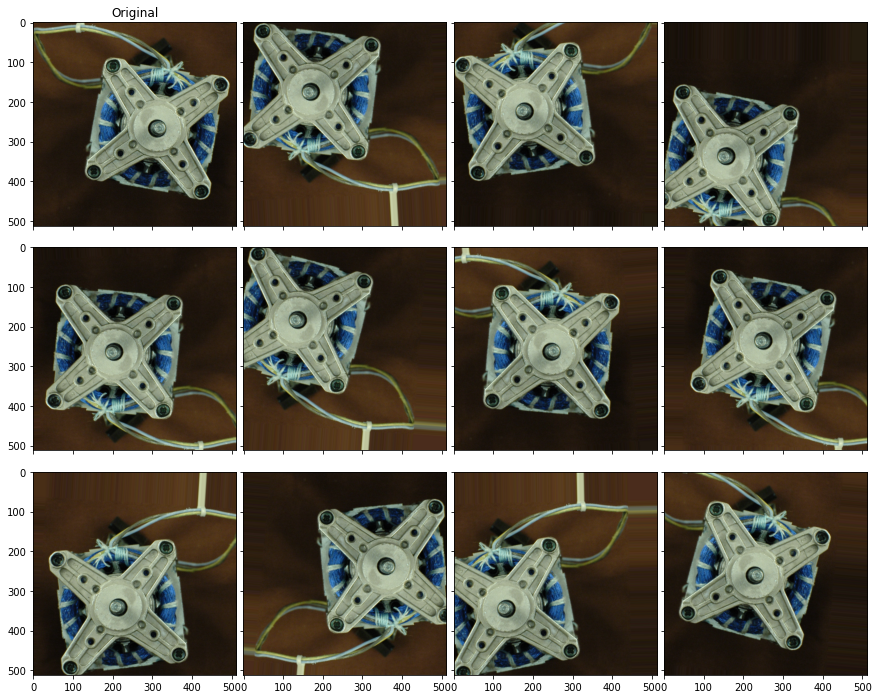

In [34]:
# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

grid[0].imshow(features[random_index])
grid[0].set_title("Original")
for i, ax in enumerate(grid[1:]):
    image = datagen.flow(features[[random_index]]).next()[0].astype(int)
    ax.imshow(image) # Plot image
plt.show()